# Customers' Holiday Bookings - British Airways

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import precision_recall_curve
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [3]:
df = pd.read_csv("C:/Users/vadre/Downloads/customer_booking.csv", encoding="ISO-8859-1")

In [4]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


In [5]:
df.shape

(50000, 14)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

## Class Imbalance

In [8]:
print(df['booking_complete'].value_counts())
print(df['booking_complete'].value_counts(normalize=True) * 100)

booking_complete
0    42522
1     7478
Name: count, dtype: int64
booking_complete
0    85.044
1    14.956
Name: proportion, dtype: float64


## Encoding

In [10]:
label_encoder = LabelEncoder()
df['sales_channel'] = label_encoder.fit_transform(df['trip_type'])
df['trip_type'] = label_encoder.fit_transform(df['trip_type'])
df['flight_day'] = label_encoder.fit_transform(df['flight_day'])

df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,2,2,262,19,7,2,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,2,2,112,20,3,2,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,2,2,243,22,17,6,AKLDEL,India,1,1,0,5.52,0
3,1,2,2,96,31,4,2,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,2,2,68,22,15,6,AKLDEL,India,1,0,1,5.52,0


In [11]:
route_freq = df['route'].value_counts().to_dict()
df['route'] = df['route'].map(route_freq)

origin_freq = df['booking_origin'].value_counts().to_dict()
df['booking_origin'] = df['booking_origin'].map(origin_freq)

In [12]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,2,2,262,19,7,2,20,1074,1,0,0,5.52,0
1,1,2,2,112,20,3,2,20,1074,0,0,0,5.52,0
2,2,2,2,243,22,17,6,20,1270,1,1,0,5.52,0
3,1,2,2,96,31,4,2,20,1074,0,0,1,5.52,0
4,2,2,2,68,22,15,6,20,1270,1,0,1,5.52,0


## Weak Correlations

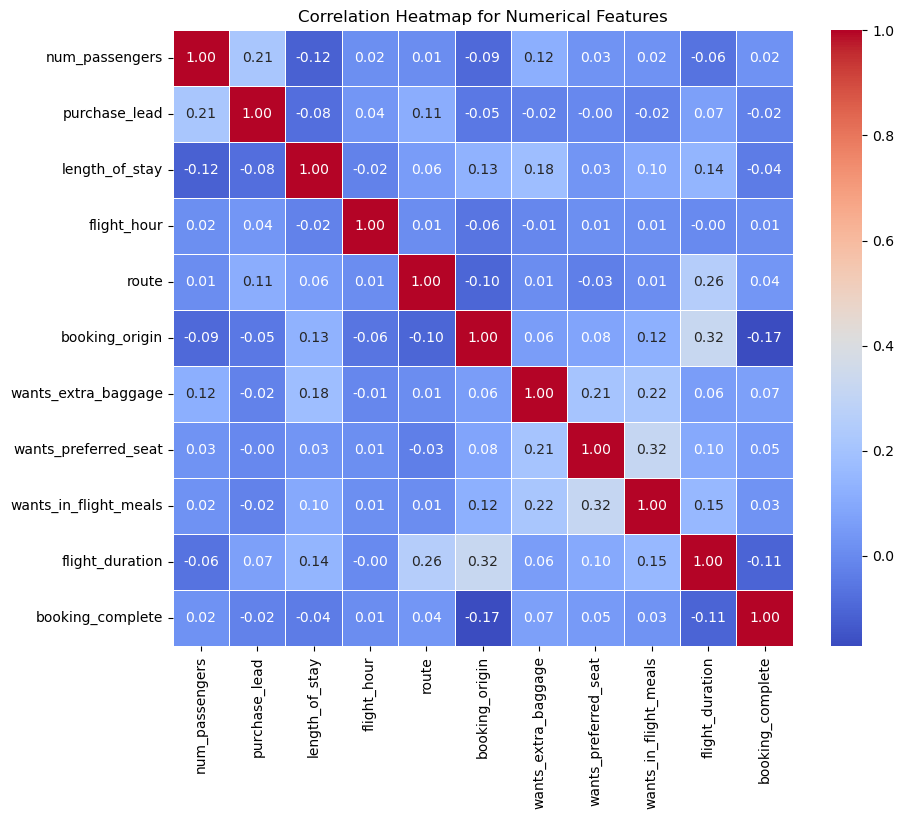

In [14]:
numerical_df = df.select_dtypes(include=['int64', 'float64'])
correlation_matrix = numerical_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.title('Correlation Heatmap for Numerical Features')
plt.show()

## Building the ML Models

In [16]:
X = df.drop(columns=['booking_complete'])  
y = df['booking_complete']  


# Split the data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)




## 1. Random Forest Classifier with weights

In [18]:
# Train Random Forest with class weight
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced", n_jobs=-1)
model.fit(X_train, y_train)

# Predict and Evaluate
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92      8504
           1       0.54      0.09      0.16      1496

    accuracy                           0.85     10000
   macro avg       0.70      0.54      0.54     10000
weighted avg       0.81      0.85      0.81     10000



## 2. Random Classifier with SMOTE

In [20]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)
print("Classification Report After SMOTE:\n", classification_report(y_test, y_pred))

Classification Report After SMOTE:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88      8504
           1       0.33      0.37      0.35      1496

    accuracy                           0.79     10000
   macro avg       0.61      0.62      0.61     10000
weighted avg       0.80      0.79      0.80     10000



## 3. XGBoost with class balancing

In [22]:
weight_ratio = (y_train == 0).sum() / (y_train == 1).sum()


xgb_model = XGBClassifier(n_estimators=100, random_state=42, scale_pos_weight=weight_ratio)
xgb_model.fit(X_train, y_train)

# Predict
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.75      0.83      8504
           1       0.32      0.66      0.43      1496

    accuracy                           0.74     10000
   macro avg       0.62      0.71      0.63     10000
weighted avg       0.84      0.74      0.77     10000



Random Forest (Without SMOTE)

- Recall for 1 (Booking Complete) is only 0.09, meaning the model is missing most of the positive cases.
- Accuracy is 85%, but it's misleading due to class imbalance.

Random Forest (With SMOTE)

- Recall improved to 0.37, but precision dropped to 0.33.
- Accuracy dropped to 79%, meaning SMOTE introduced some noise.

XGBoost (With Scale_Pos_Weight)

- Best recall for 1: 0.66 (Huge improvement from 0.09 and 0.37).
- Lower precision (0.32), meaning more false positives.
- Accuracy dropped to 74%, but that's expected since we're focusing on improving recall.

## Feature Importance

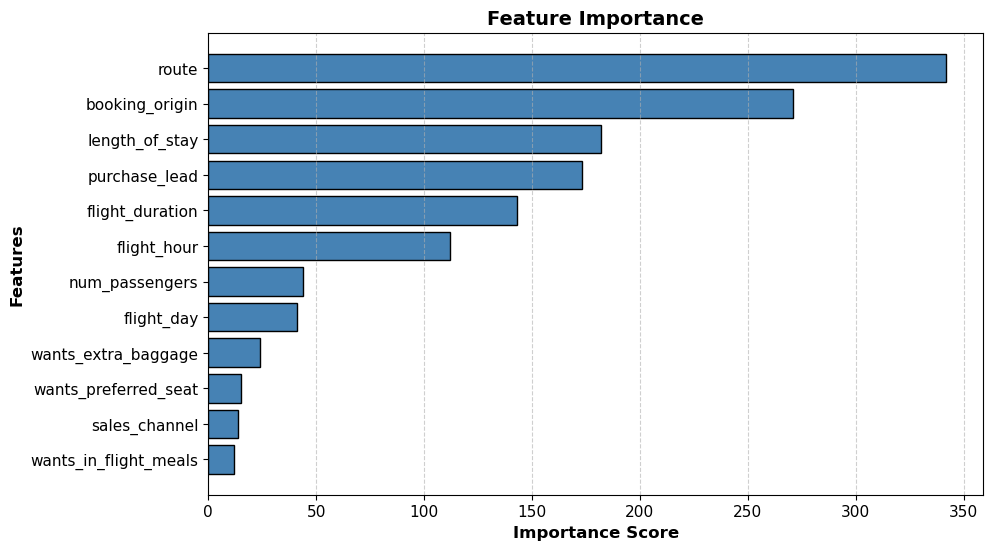

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# Feature importance data
features = [
    "route", "booking_origin", "length_of_stay", "purchase_lead", "flight_duration", 
    "flight_hour", "num_passengers", "flight_day", "wants_extra_baggage", 
    "wants_preferred_seat", "sales_channel", "wants_in_flight_meals"
]
importance_scores = [342, 271, 182, 173, 143, 112, 44, 41, 24, 15, 14, 12]

# Create a DataFrame
df_importance = pd.DataFrame({"Feature": features, "Importance": importance_scores})
df_importance = df_importance.sort_values(by="Importance", ascending=True)  # Sort for better visuals

# Plot
plt.figure(figsize=(10, 6))
plt.barh(df_importance["Feature"], df_importance["Importance"], color="steelblue", edgecolor="black")

# Styling
plt.xlabel("Importance Score", fontsize=12, fontweight="bold")
plt.ylabel("Features", fontsize=12, fontweight="bold")
plt.title("Feature Importance", fontsize=14, fontweight="bold")
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Display plot
plt.show()


## Hyperparameter Tuning

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
import numpy as np

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2, 0.3],
    'scale_pos_weight': [weight_ratio],  # Use your computed weight ratio
    'reg_lambda': [0, 1, 5, 10],
    'reg_alpha': [0, 1, 5, 10]
}

# Initialize classifier
xgb_model = XGBClassifier(random_state=42)

# RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=20,  # Number of random iterations
    scoring='f1',  # You can change this to 'roc_auc' or 'accuracy' as needed
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print best parameters
print("Best Parameters:", random_search.best_params_)

# Use the best model to make predictions
best_xgb_model = random_search.best_estimator_
y_pred_xgb = best_xgb_model.predict(X_test)

# Print Classification Report
from sklearn.metrics import classification_report
print("Optimized XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'subsample': 0.6, 'scale_pos_weight': 5.686726847208291, 'reg_lambda': 5, 'reg_alpha': 0, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.8}
Optimized XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.72      0.82      8504
           1       0.31      0.71      0.43      1496

    accuracy                           0.72     10000
   macro avg       0.62      0.72      0.63     10000
weighted avg       0.84      0.72      0.76     10000

